In [1]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from scipy import special as sp
from scipy import stats as st
from sklearn.preprocessing import QuantileTransformer as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch_cubic_spline_grids import CubicBSplineGrid2d

import tqdm


In [2]:
df = pd.read_csv('LUXEDumpFiles_FullSim_0p06BX_DetId33_ForStudents.csv')
df_neutrons = df[df[' pdg'].isin([2112])]
# df_photons  = df[df[' pdg'].isin([22])]

KeyboardInterrupt: 

In [ ]:
param_list = [" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"]
df_N = df_neutrons.loc[:5000000,param_list]
# df_P = df_photons.loc[:,param_list]
torch_tensor = torch.tensor(df_N[param_list].values)

N_data = TensorDataset(torch_tensor,torch.ones(len(torch_tensor)))


In [219]:
df_N = pd.read_csv('Full_Sim_10M.csv')

In [41]:
net_xy =  CubicBSplineGrid2d(resolution=(400,400))
net_et =  CubicBSplineGrid2d(resolution=(400,400))
net_rth = CubicBSplineGrid2d(resolution=(400,400))
net_xy.load_state_dict(torch.load('xy_Corr.py'))
net_et.load_state_dict(torch.load('et_Corr.py'))
net_rth.load_state_dict(torch.load('rth_Corr.py'))
net_xy.eval()
net_et.eval()
net_rth.eval()

CubicBSplineGrid2d()

In [220]:
def plot_correlations(x,y,bins=[400,400],loglog=False,Xlim=None,Ylim=None):
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  if Xlim!=None:
      plt.xlim(Xlim)
  if Ylim!=None:
      plt.ylim(Ylim)
  plt.colorbar()
  plt.show()


In [405]:
def plots(df):
  plot_correlations(-np.cos(df[' phi_x'])*df[' rx'],-np.sin(df[' phi_x'])*df[' rx'])
  Ebin = 200# 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),400)
  Tbin = 200 #10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),400)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin]) #, loglog=True
  plot_correlations(df[' rx'],df['theta'])

In [391]:
df_N[' rx'] = np.sqrt(df_N[' xx'].values**2 + df_N[' yy'].values**2)
th_N = np.arccos(df_N[' pzz'].values/np.sqrt(df_N[' pxx'].values**2+df_N[' pyy'].values**2+df_N[' pzz'].values**2))
#th_N = np.arctan(df_N[' yy'].values/df_N[' pxx'].values)+np.pi/2
df_N['theta']=th_N
plots(df_N)
print(df_N.shape)

KeyError: ' phi_x'

In [433]:
class ParticleDataset(Dataset):
  def __init__(self, data_path, norm_path,QT):
    super().__init__()
    self.data = pd.read_csv(data_path)
    # self.data = self.data[self.data[' pdg'].isin([2112])]  # 22 - photons , 2112 - neutrons
    self.data[' rx'] = np.sqrt(self.data[' xx'].values**2 + self.data[' yy'].values**2)
    self.data[' rp'] = np.sqrt(self.data[' pxx'].values**2 + self.data[' pyy'].values**2)
    self.data[' phi_p'] = np.arctan2(self.data[' pxx'].values,self.data[' pyy'].values) + np.pi
    self.data[' phi_x'] = np.arctan2(self.data[' xx'].values,self.data[' yy'].values) + np.pi
    self.data = self.data[[" rx"," phi_x"," rp"," phi_p"," pzz"," eneg"," time"]]
    self.data['theta'] = np.arccos(self.data[' pzz'].values/np.sqrt(self.data[' rx'].values**2+self.data[' pzz'].values**2))
    self.norm = pd.read_csv(norm_path, index_col=0)
    for col in self.norm.index:
        self.data[col] = (self.data[col] - self.norm['min'][col]+ 10**(-5))/(self.norm['max'][col]-self.norm['min'][col]+2*10**(-5))
    self.data[' pzz'] = 1 - self.data[' pzz']
    self.data[[' rp',' pzz',' eneg',' time']]= np.log(self.data[[' rp',' pzz',' eneg',' time']])
    self.preprocess = self.data.values
    self.quantiles = QT.fit(self.data)
    self.data = QT.fit_transform(self.data)
    #self.data = np.sqrt(2)*sp.erfinv(2*self.data-1)
    self.data = self.data.astype(np.float32)
  def __getitem__(self, item):
    return self.data[item, :]
  def __len__(self):
    return self.data.shape[0]

In [434]:
QT = qt(output_distribution='normal',n_quantiles=5000)
dataset = ParticleDataset('Full_Sim_10M.csv', 'Full_Sim_55M_stats.csv',QT)
dataloader = DataLoader(dataset.data[:,:7], batch_size = 256, shuffle = True)

In [419]:
params = dataset.quantiles.get_params
print(params)

<bound method BaseEstimator.get_params of QuantileTransformer(n_quantiles=5000, output_distribution='normal')>


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


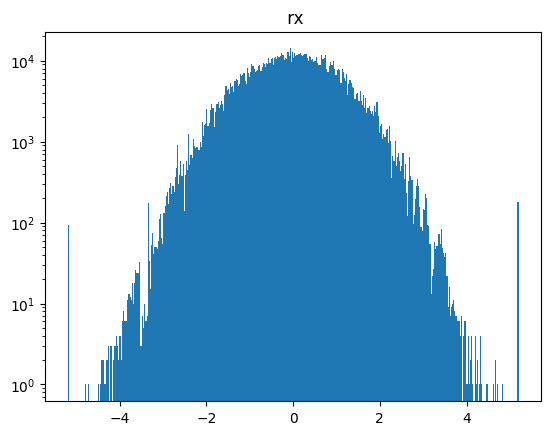

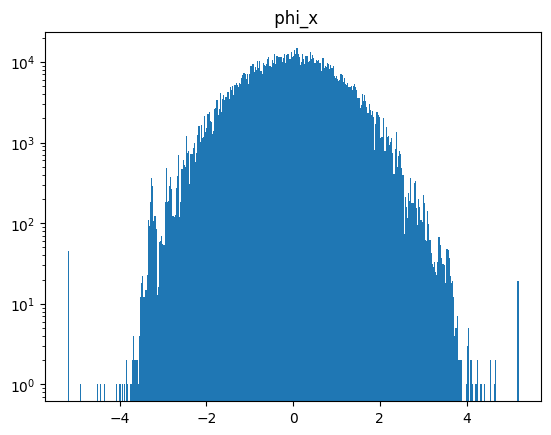

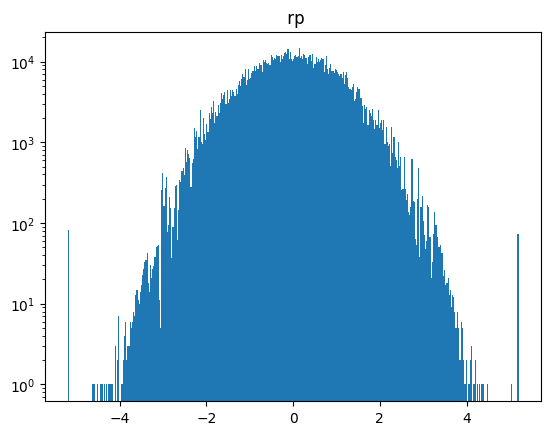

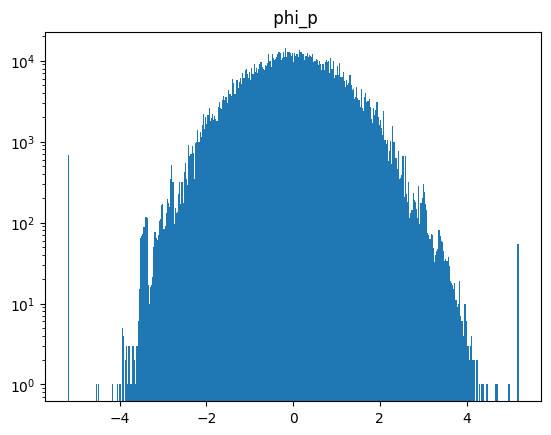

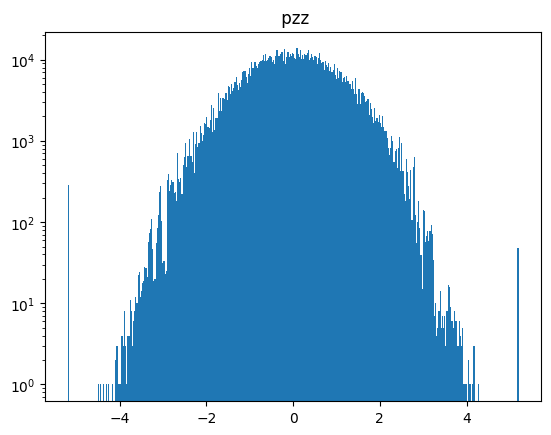

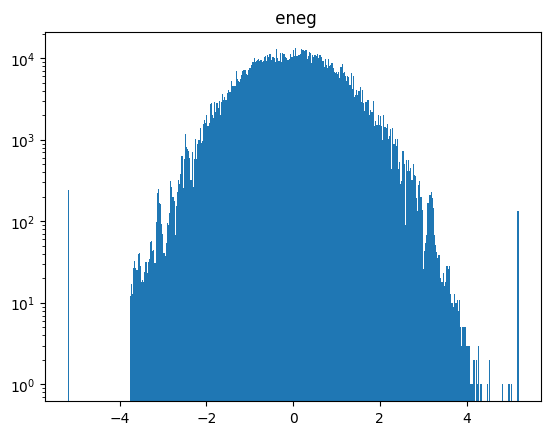

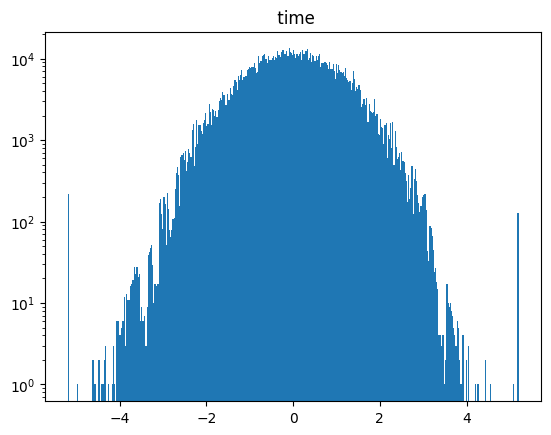

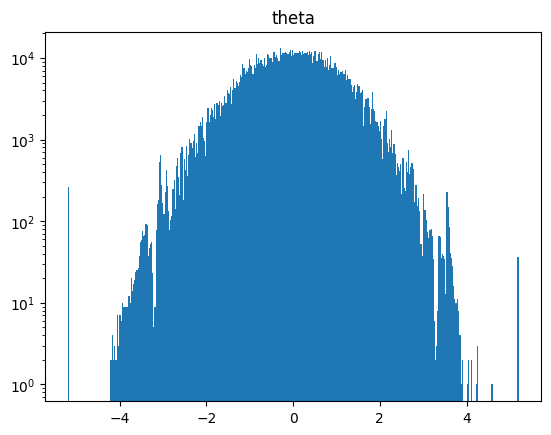

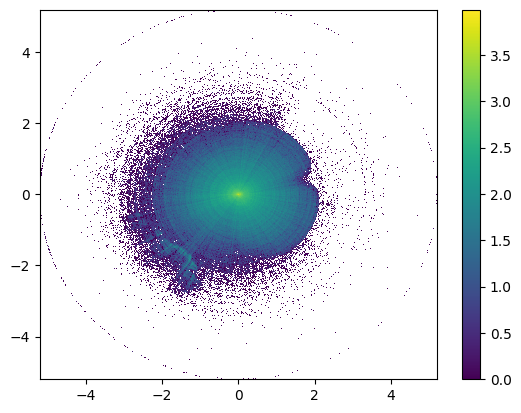

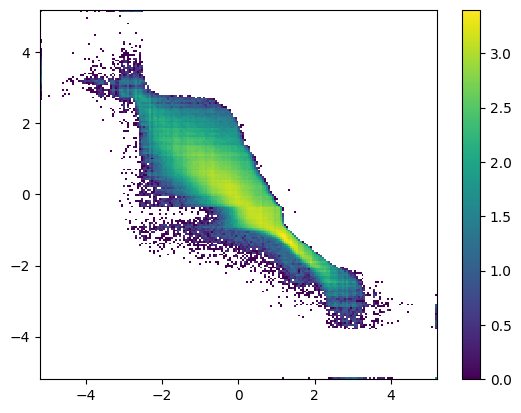

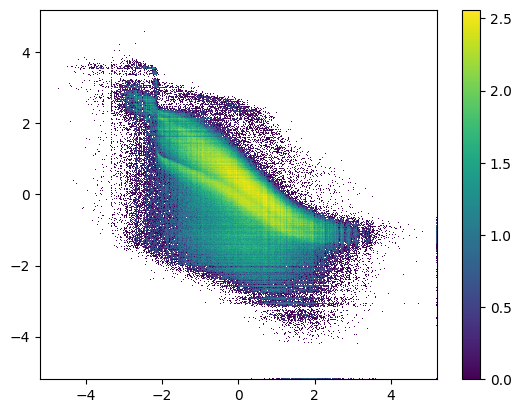

In [420]:
param_list = [" rx"," phi_x"," rp"," phi_p"," pzz"," eneg"," time","theta"]
check = pd.DataFrame([])
for i in range(8):
    plt.hist(dataset.data[:,i],bins=400)
    check[param_list[i]] = dataset.data[:,i]
    plt.yscale('log')
    plt.title(param_list[i])
    plt.figure()
plots(check)
plt.show()

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


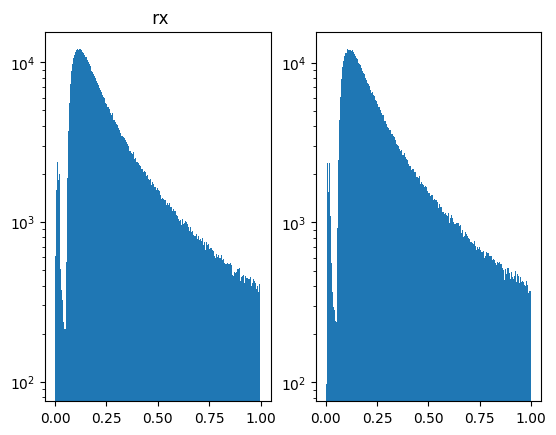

<Figure size 640x480 with 0 Axes>

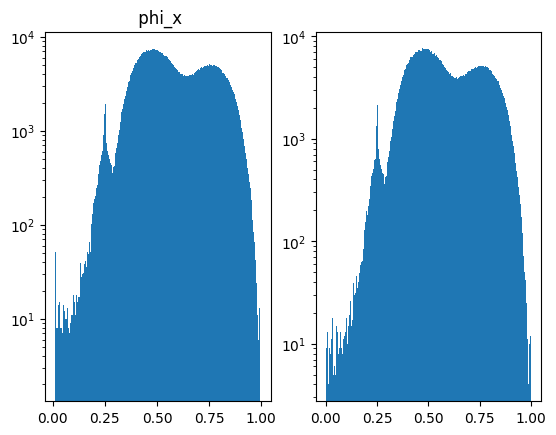

<Figure size 640x480 with 0 Axes>

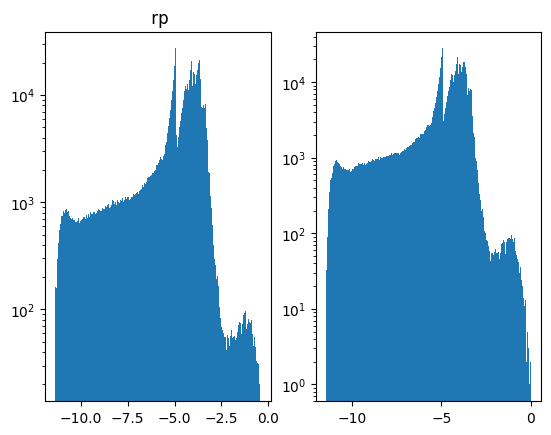

<Figure size 640x480 with 0 Axes>

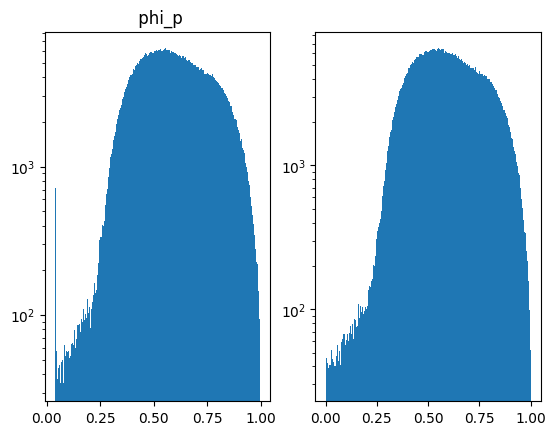

<Figure size 640x480 with 0 Axes>

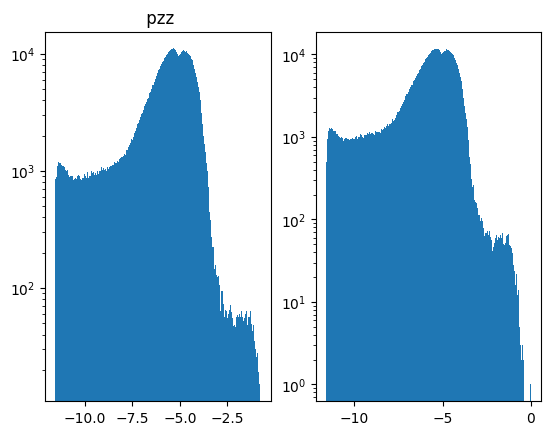

<Figure size 640x480 with 0 Axes>

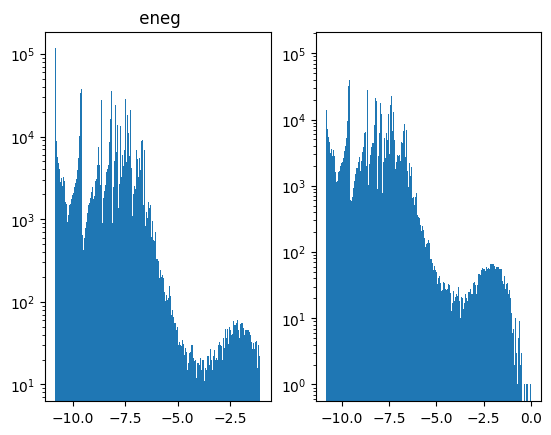

<Figure size 640x480 with 0 Axes>

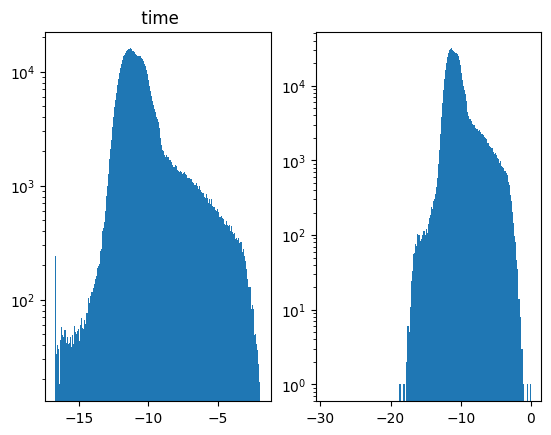

<Figure size 640x480 with 0 Axes>

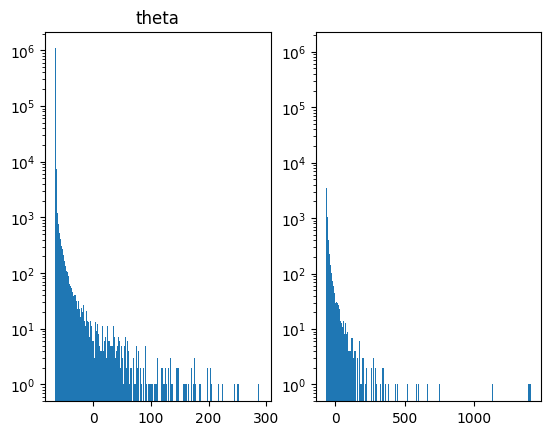

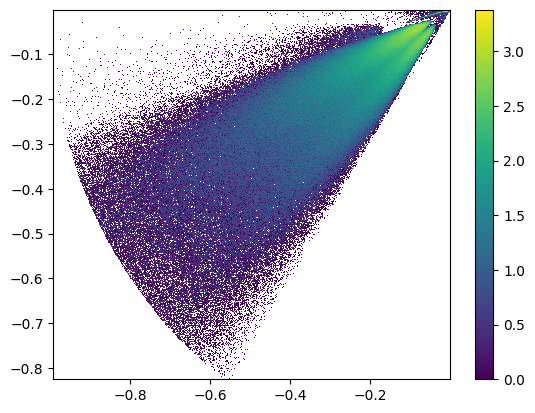

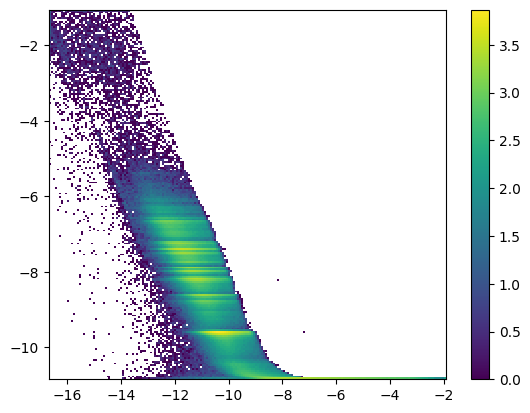

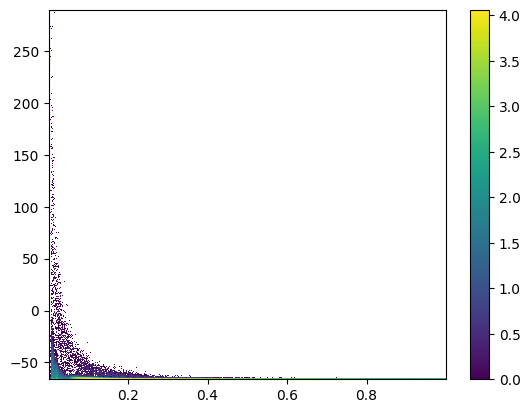

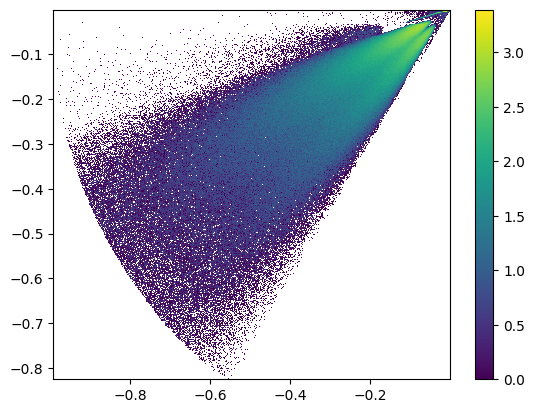

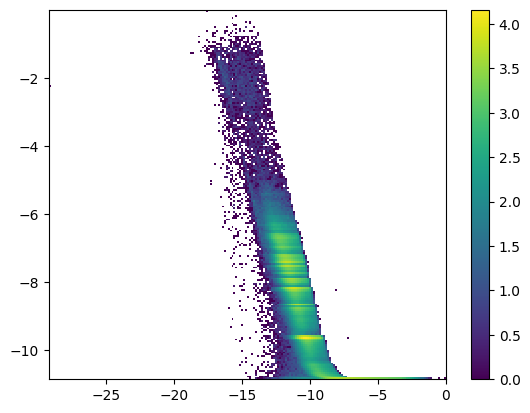

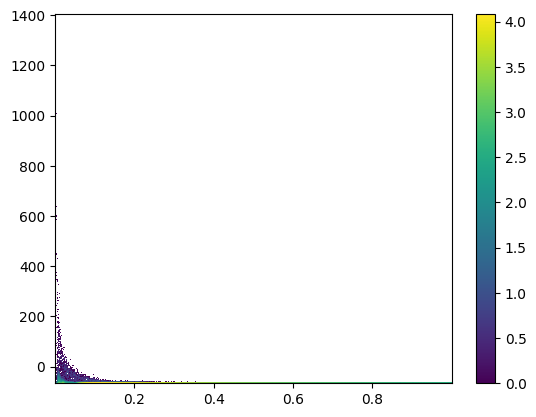

In [421]:
A = dataset.quantiles.inverse_transform(dataset.data)
check = pd.DataFrame([])
check_pre = pd.DataFrame([])
for i in range(8):
    fig , axs = plt.subplots(1,2)
    axs[0].hist(A[:,i],bins=400)
    axs[1].hist(dataset.preprocess[:,i],bins=400)
    check[param_list[i]] = A[:,i]
    check_pre[param_list[i]] = dataset.preprocess[:,i]
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].set_title(param_list[i])
    plt.figure()
plots(check)
plots(check_pre)
plt.show()

In [426]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      
      N_z = 50
        
      self.main = nn.Sequential(
        nn.Linear(N_z,25,bias=False),
        nn.LeakyReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,15,bias=False),
        nn.LeakyReLU(),
        nn.BatchNorm1d(15),
        nn.Linear(15,9,bias=False),
        nn.LeakyReLU(),
        nn.BatchNorm1d(9),
        nn.Linear(9,7)
      )
    def forward(self, input):
      return self.main(input)
      

In [427]:
class Discriminator(nn.Module):
    def __init__(self):
      super().__init__()
        
      self.main = nn.Sequential(
        nn.Linear(7,50),
        nn.LeakyReLU(),
        nn.InstanceNorm1d(50),
        nn.Linear(50,25),
        nn.LeakyReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,10),
        nn.LeakyReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10,1,bias=False)
      )
    def forward(self, input):
      return self.main(input)
    

In [428]:
mps_device = torch.device('mps')
net_G = Generator().to(mps_device)
net_D = Discriminator().to(mps_device)

print(net_G,net_D)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=15, bias=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=9, bias=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=9, out_features=7, bias=True)
  )
) Discriminator(
  (main): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): InstanceNorm1d(50, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Linear(in_features=50, out_features=25, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (

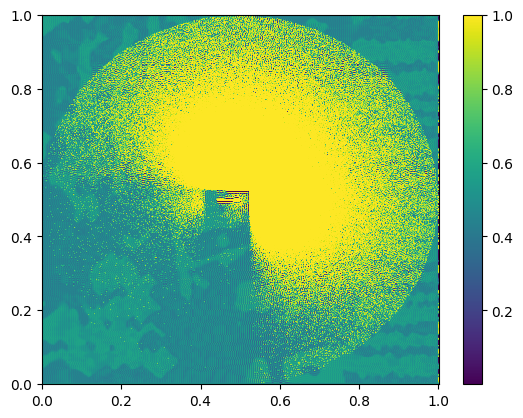

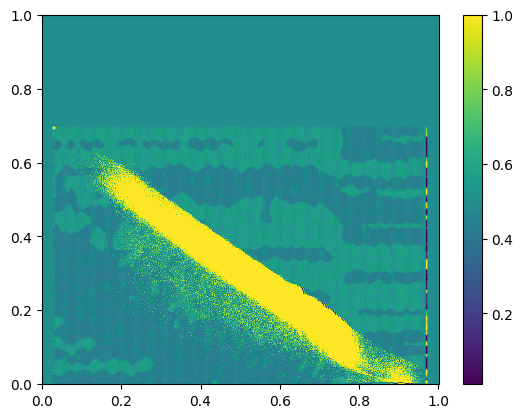

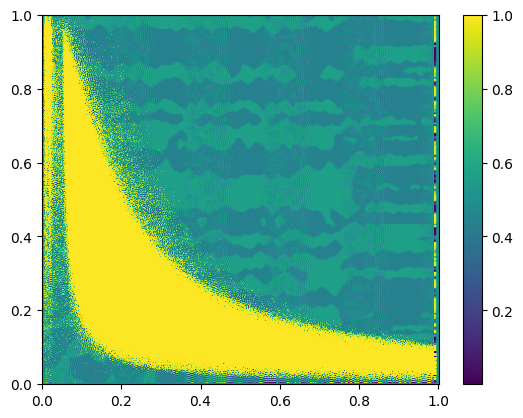

In [429]:
x = torch.linspace(0,1,400)
y = torch.linspace(0,1,400)
net_xy.eval()
net_et.eval()
net_rth.eval()
Rxy  = torch.zeros([400,400])
Ret  = torch.zeros([400,400])
Rrth = torch.zeros([400,400])
for i in range(400):
    X = torch.ones([len(y),1])*x[i]
    Y = y.view(len(y),1)
    Rxy[:,i] = net_xy(torch.cat([X,Y],dim=1))[:,0]
    Ret[:,i] = net_et(torch.cat([X,Y],dim=1))[:,0]
    Rrth[:,i]= net_rth(torch.cat([X,Y],dim=1))[:,0]
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,torch.sigmoid(Rxy).detach().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(X,Y,torch.sigmoid(Ret).detach().numpy())
plt.colorbar()
plt.figure()
plt.pcolormesh(X,Y,torch.sigmoid(Rrth).detach().numpy())
plt.colorbar()
plt.show()

In [230]:
class Correlation_Loss(nn.Module):
    def __init__(self,net_xy,net_et,net_rth):
        super().__init__()
        self.net_xy = net_xy.to('cpu')
        self.net_et = net_et.to('cpu')
        self.net_rth = net_rth.to('cpu')
        
    def forward(self, pred):
        loss_xy = self.net_xy(pred[:,[1,0]])
        loss_et = self.net_et(pred[:,[6,5]])
        r = (torch.sqrt(pred[:,0]**2+pred[:,1]**2)).view(len(pred),1)
        theta = (torch.arccos(pred[:,4]/(torch.sqrt(pred[:,2]**2+pred[:,3]**2+pred[:,4]**2)))).view(len(pred),1)
        loss_rth = self.net_rth(torch.cat([theta,r],dim=1))
        sum = -(torch.sigmoid(loss_xy)+torch.sigmoid(loss_et)+torch.sigmoid(loss_rth))
        return sum
    

In [430]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.0 ,10**(-1))
    elif isinstance(m,nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1,0.02)

In [431]:
loss_func = Correlation_Loss(net_xy,net_et,net_rth)
N_z=50
real_label = 1
fake_label = 0
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/950420148.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/950420148.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/950420148.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df[' xx']= fake[:,0]
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/950420148.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

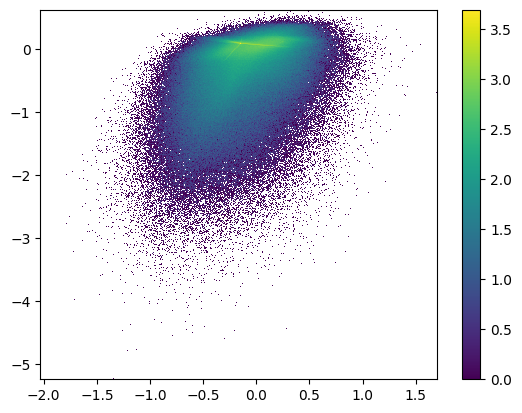

0/100	Loss_D: -0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

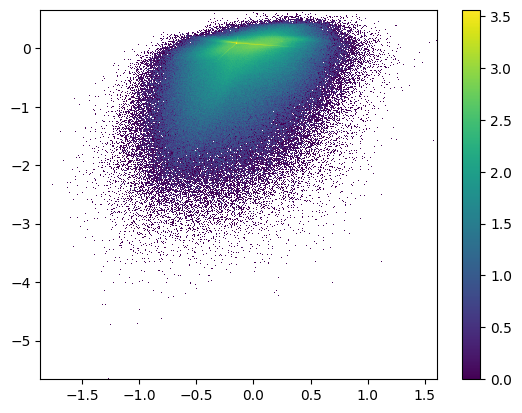

1/100	Loss_D: 0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

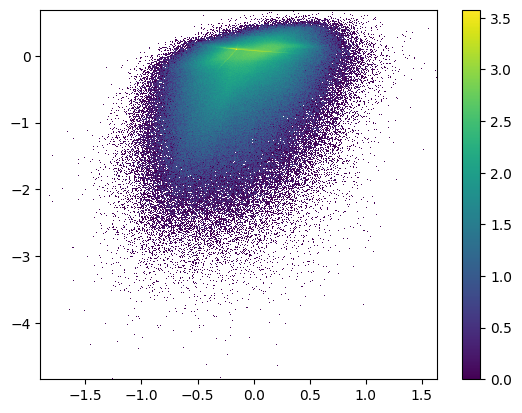

2/100	Loss_D: -0.0000	Loss_G: -0.0000


 batch: 0it [00:00, ?it/s]

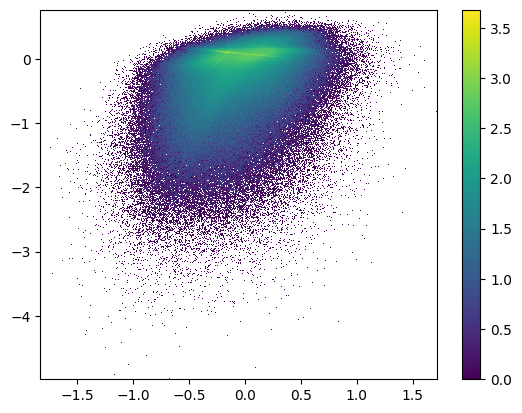

3/100	Loss_D: 0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

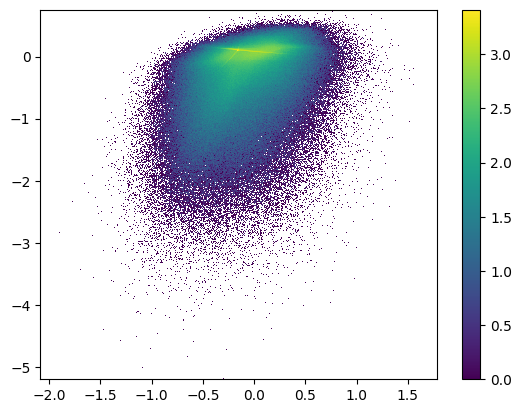

4/100	Loss_D: -0.0000	Loss_G: -0.0000


 batch: 0it [00:00, ?it/s]

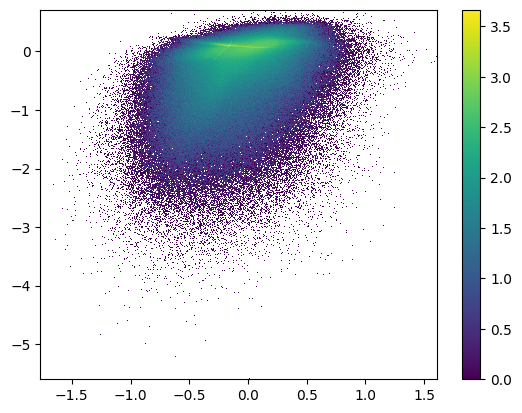

5/100	Loss_D: -0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

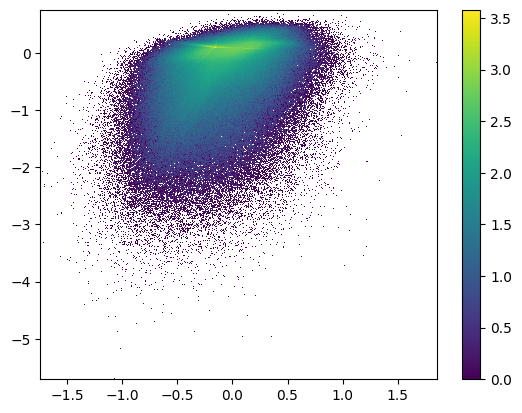

6/100	Loss_D: -0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

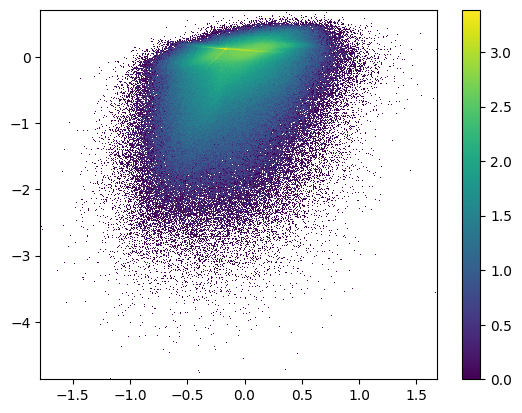

7/100	Loss_D: -0.0000	Loss_G: -0.0000


 batch: 0it [00:00, ?it/s]

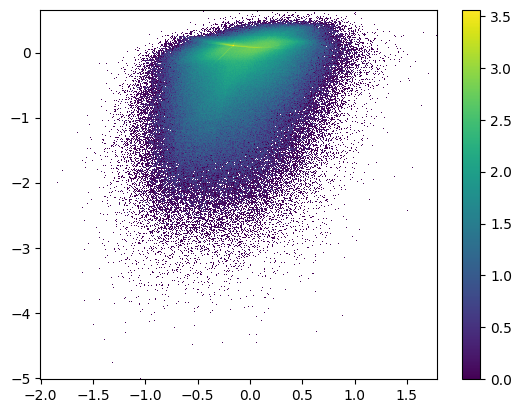

8/100	Loss_D: 0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

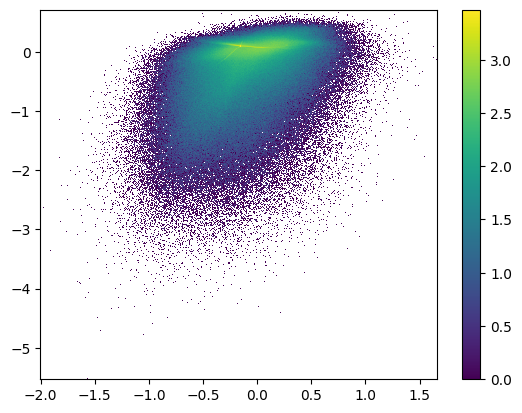

9/100	Loss_D: -0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

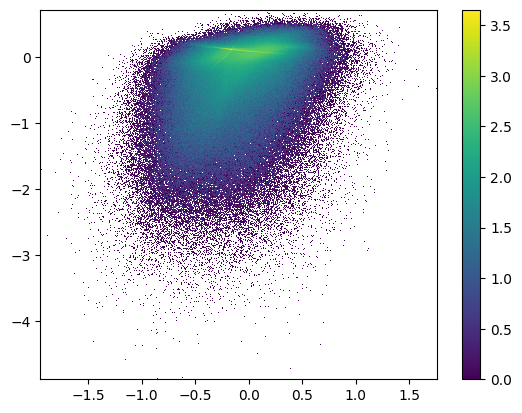

10/100	Loss_D: 0.0000	Loss_G: 0.0000


 batch: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [435]:
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

net_G.apply(weights_init)
net_D.apply(weights_init)
generated_df = df_N[[' xx',' yy']]

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):
    net_G.to(mps_device)
    net_G.train()

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        b_size = len(data)
        real_data = data.to(mps_device)
        
        output = net_D(real_data)

        err_D_real = -torch.mean(output)
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        output = net_D(fake_p.detach())
        err_D_fake = torch.mean(output)
        fake_p.to(mps_device)
        err_D = err_D_real + err_D_fake
        err_D.backward()

        # update the discriminator network
        optimizer_D.step()
        
        # Update the Generator network
        net_G.zero_grad()
        output = net_D(fake_p)
        err_G = -torch.mean(output) # + torch.mean(loss_func(fake_p.cpu()))
        err_G.backward()
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        iters += 1

    avg_error_G = avg_error_G/len(dataloader.dataset)
    avg_error_D = avg_error_D/len(dataloader.dataset)
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    noise = torch.randn(1154756, N_z, device='cpu')
    net_G.eval()
    net_G.to('cpu')
    fake = net_G(noise).detach().numpy()
    generated_df[' xx']= fake[:,0]
    generated_df[' yy']= fake[:,1]
    plot_correlations(generated_df[' xx'], generated_df[' yy'])
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

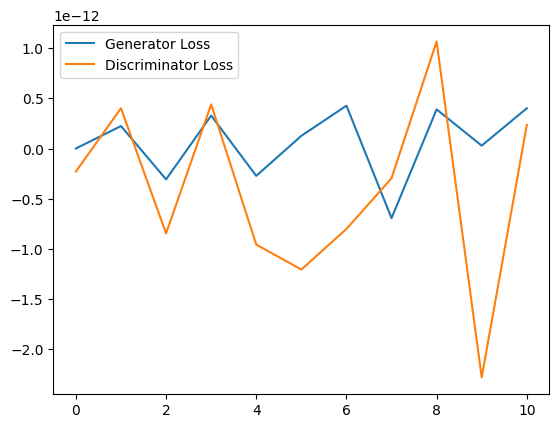

In [456]:
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()

In [479]:
noise = torch.randn(1154756, N_z, device='cpu')
net_G.eval()
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_66569/3865013566.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


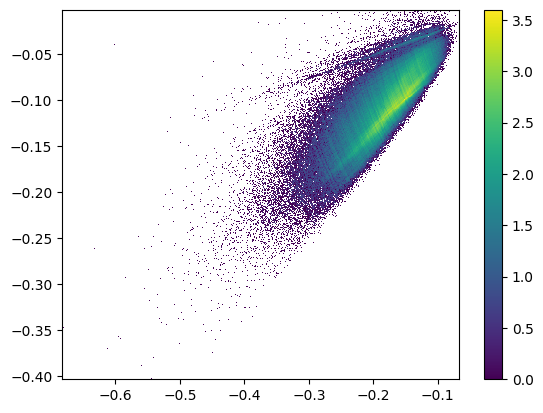

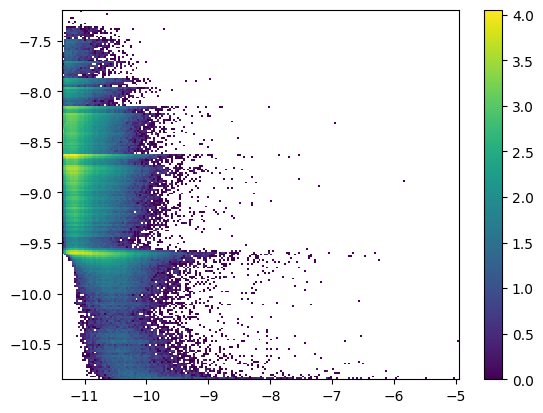

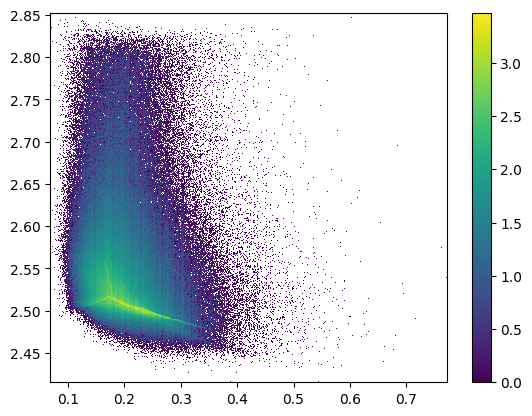

In [480]:
generated_df = pd.DataFrame([])
param_list = [' rx',' phi_x',' rp',' phi_p',' pzz',' eneg',' time','theta']
add = np.array([np.arccos(fake_p[:,4]/(np.sqrt(fake_p[:,4]**2+fake_p[:,2]**2)))]).T
fake_p = np.hstack((fake_p,add))
A_p = dataset.quantiles.inverse_transform(fake_p)
for i in range(len(param_list)):
    generated_df[param_list[i]]= A_p[:,i]
#generated_df[[' eneg',' time']]=generated_df[[' eneg',' time']]-np.min(generated_df[[' eneg',' time']])+10**(-5)

th_g = np.arccos(generated_df[' pzz'].values/np.sqrt(generated_df[' rp'].values**2+generated_df[' pzz'].values**2))
generated_df['theta']=th_g
plots(generated_df)

#plots(df_N)

<function matplotlib.pyplot.show(close=None, block=None)>

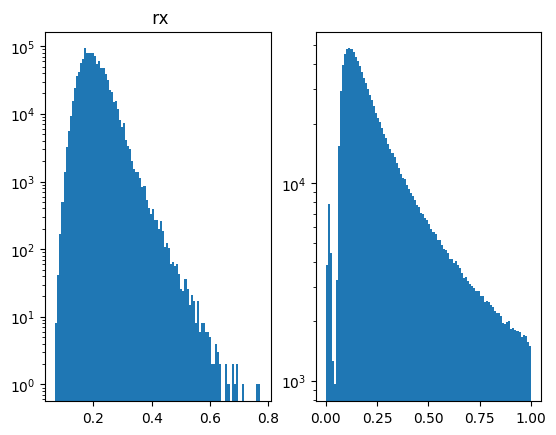

<Figure size 640x480 with 0 Axes>

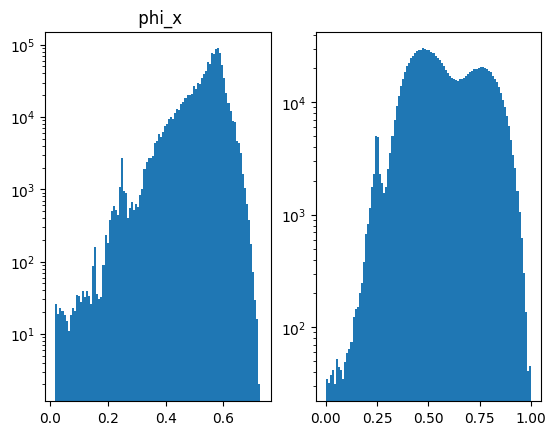

<Figure size 640x480 with 0 Axes>

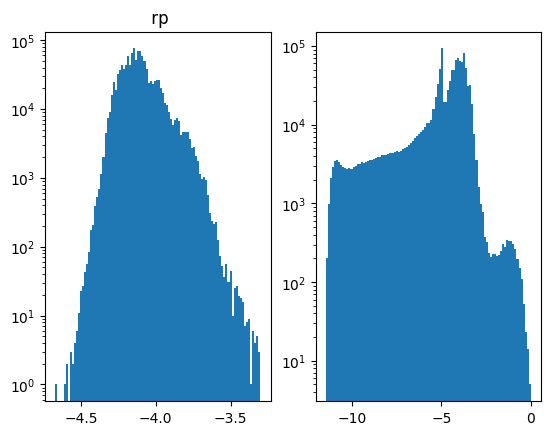

<Figure size 640x480 with 0 Axes>

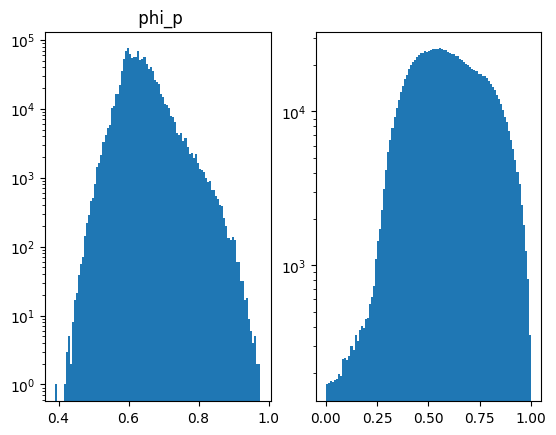

<Figure size 640x480 with 0 Axes>

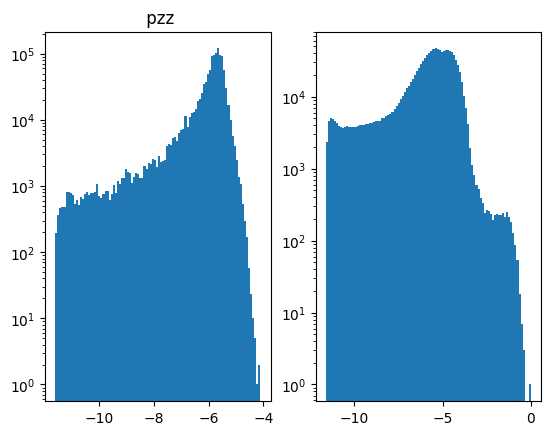

<Figure size 640x480 with 0 Axes>

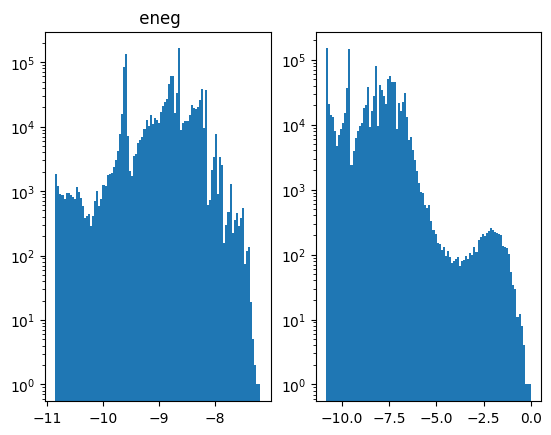

<Figure size 640x480 with 0 Axes>

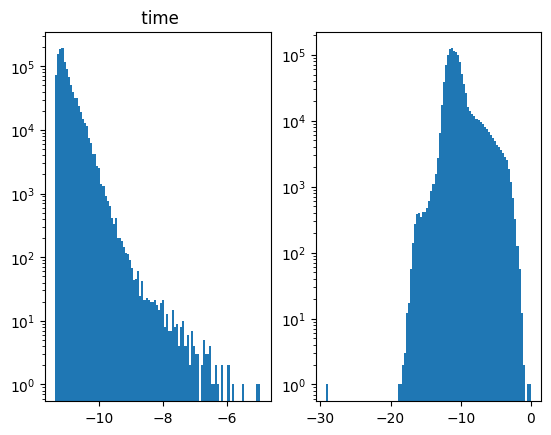

<Figure size 640x480 with 0 Axes>

In [481]:
for i in range(7):
    fig, axs = plt.subplots(1,2,squeeze=False)
    axs[0,0].hist(generated_df[param_list[i]],bins=100)
    axs[0,1].hist(dataset.preprocess[:,i],bins=100)
    axs[0,0].set_title(param_list[i])
    axs[0,0].set_yscale('log')
    axs[0,1].set_yscale('log')
    plt.figure()
plt.show

In [657]:
torch.save(net_G.state_dict(), 'saved_Gen.pt')

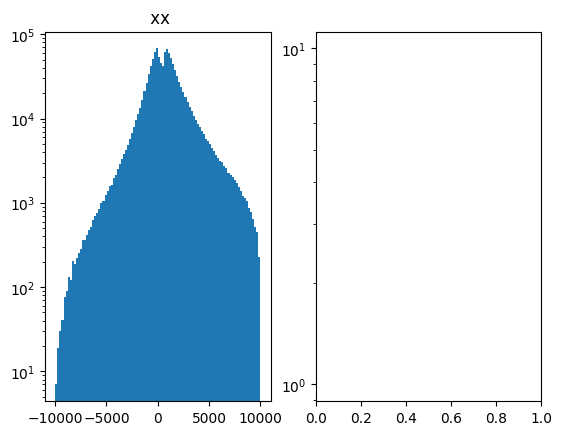

<Figure size 640x480 with 0 Axes>

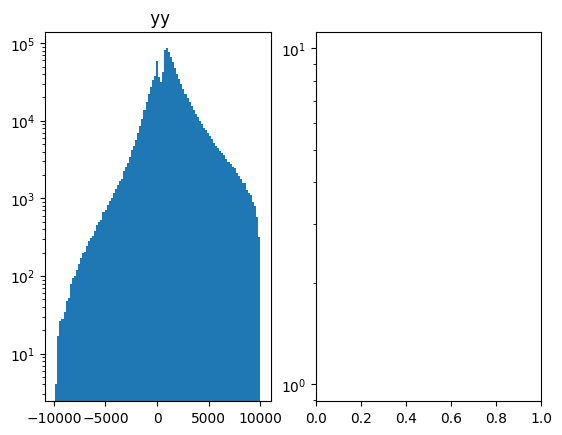

<Figure size 640x480 with 0 Axes>

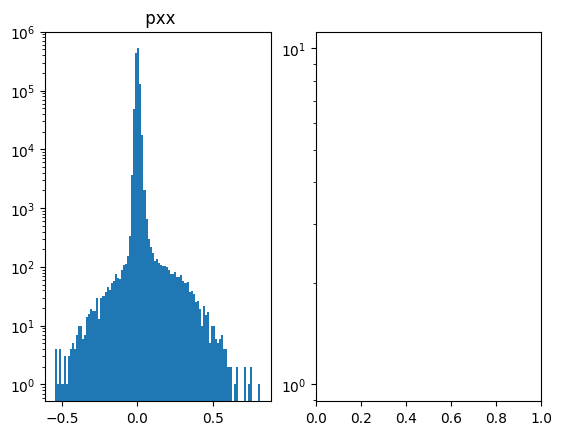

<Figure size 640x480 with 0 Axes>

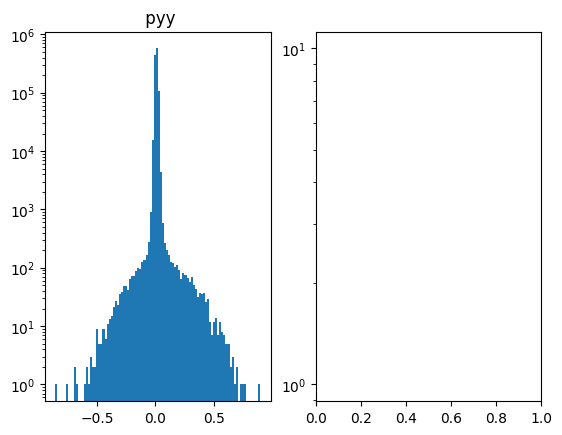

<Figure size 640x480 with 0 Axes>

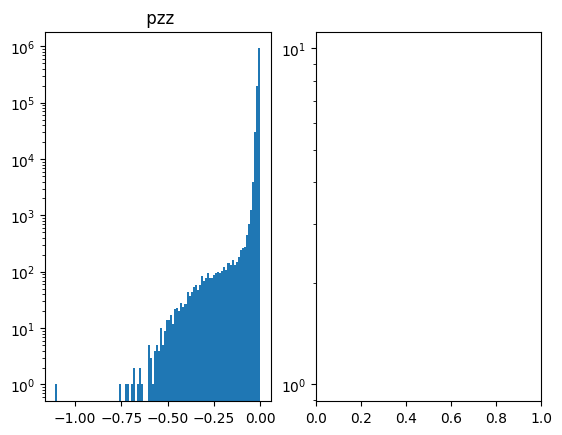

<Figure size 640x480 with 0 Axes>

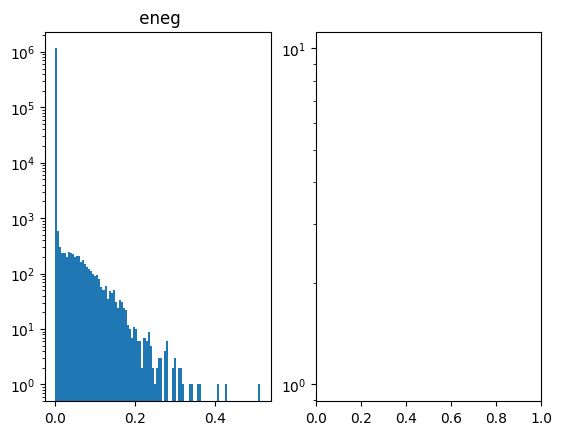

<Figure size 640x480 with 0 Axes>

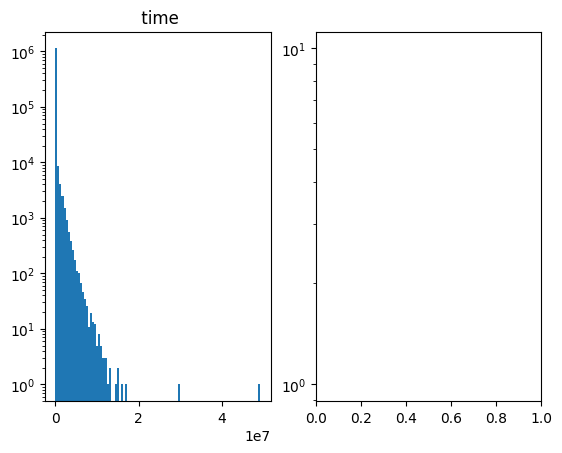

<Figure size 640x480 with 0 Axes>

In [217]:
for i in range(7):
    fig, axs = plt.subplots(1,2,squeeze=False)
    axs[0,0].hist(df_N[param_list[i]],bins=100)
    axs[0,0].set_yscale('log')
    #axs[0,1].hist(dataset.data[:,i],bins=100)
    axs[0,0].set_title(param_list[i])
    plt.yscale('log')
    plt.figure()
plt.show()